In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('png')
import seaborn as sns
sns.set_context("paper")
sns.set_style("ticks");

# Homework 7

## References

+ Module 5: Inverse problems in deterministic scientifc models
    - Purely data-driven learning of dynamical systems

+ Module 6: Physics-informed neural networks
   - PINNs basics
   - PINNs for parametric studies
   - PINNs for inverse problems

<!-- + Module 7: Inverse problems in stochastic scientific models
    - Stochastic differential equations -->

## Instructions

+ Type your name and email in the "Student details" section below.
+ Develop the code and generate the figures you need to solve the problems using this notebook.
+ For the answers that require a mathematical proof or derivation you should type them using latex. If you have never written latex before and you find it exceedingly difficult, we will likely accept handwritten solutions.
+ The total homework points are 100. Please note that the problems are not weighed equally.

## Student details

+ **First Name:**Yikai
+ **Last Name:**Liu
+ **Email:**liu3307@purdue.edu
+ **Used generative AI to complete this assignment (Yes/No):**No
+ **Which generative AI tool did you use (if applicable)?:**No

# Problem 1 - Partially Observed Lorenz System

In [2]:
import numpy as np
import scipy

sigma = 10.0
rho = 28.0
beta = 8.0 / 3.0
dt = 0.01
num_steps = int(20.0 / dt)
ts = np.linspace(0, 100, num_steps)
x0 = np.array([-8.0, 7.0, 27.0])

def vector_field(x, t):
    return (
        sigma * (x[1] - x[0]),
        x[0] * (rho - x[2]) - x[1],
        x[0] * x[1] - beta * x[2]
    )
xs = scipy.integrate.odeint(vector_field, x0, ts)

# Find the exact derivatives - no noise
from jax import vmap, jit
vf = jit(vmap(vector_field, in_axes=(0, 0)))
dxs = np.array(vf(xs, ts)).T

The data you should use are these:

In [3]:
partial_xs = xs[:, 0]
partial_dxs = dxs[:, 0]

## Part A - Applying SINDY on a partially observed system

Try to apply SINDY on `partial_xs` and `partial_dxs`.
Just try to express the right-hand-side of the dynamics using a high order polynomial.
Do not use anything fancier as there is no way this can work.
Demonstrate using some validation data that this doesn't work.

**Answer:**

MSE on training data: 1751.6003194251275


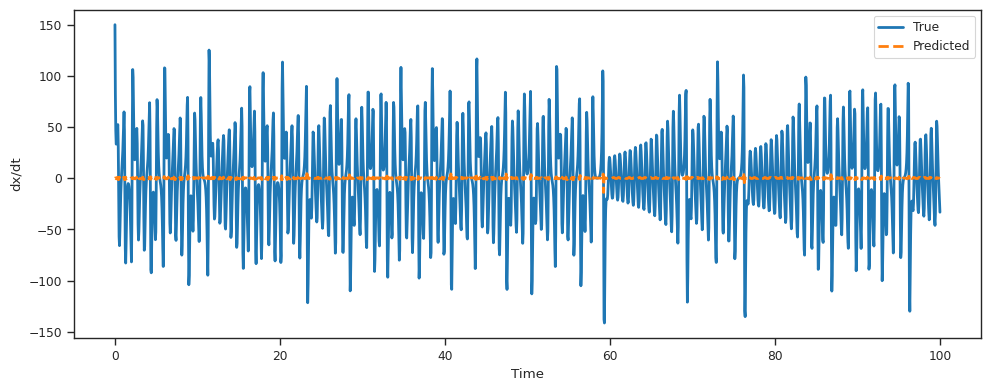

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression


partial_xs = xs[:, 0]
partial_dxs = dxs[:, 0]
poly_order = 10
poly = PolynomialFeatures(degree=poly_order, include_bias=False)
X_poly = poly.fit_transform(partial_xs.reshape(-1, 1))

model = LinearRegression()
model.fit(X_poly, partial_dxs)
dxs_pred = model.predict(X_poly)
mse = np.mean((dxs_pred - partial_dxs) ** 2)
print(f"MSE on training data: {mse}")
plt.figure(figsize=(10, 4))
plt.plot(ts, partial_dxs, label="True", linewidth=2)
plt.plot(ts, dxs_pred, "--", label="Predicted", linewidth=2)
plt.xlabel("Time")
plt.ylabel("dx/dt")
plt.legend()
plt.tight_layout()
plt.show()


## Part B - The Hankel Matrix

Part A failed because we tried to fit Markovian dynamics to a partially observed state.
There are no Markovian dynamics for partially observed states.
Partially observed states exhibit effective dynamics that appear to have memory (and noise).
The Hankel matrix is a way to create variables that account for memory.
We will try two variations.
First, we will just try to learn dynamics directly on the columns of the Hankel matrix.
This is not going to work if the memory we need is long.
Then, we will use SVD to reduce the dimensionality of the Hankel matrix before attempting to learn the dynamics.

Your data are $x(t_1),\dots,x(t_m)$.
The Hankel matrix is:

$$
\mathbf{H}_\ell = \begin{bmatrix}
x(t_1) & x(t_2) & x(t_3) & \dots x(t_{m-\ell})\\
x(t_2) & x(t_3) & x(t_4) & \dots x(t_{m-\ell+1})\\
\vdots & \vdots & \vdots & \dots \vdots\\
x(t_\ell) & x(t_{\ell+1}) & x(t_{\ell+3}) \dots & x(t_m)
\end{bmatrix}
$$

Write a function that forms the Hankel matrix given the data and $\ell$.

**Answer:**

In [5]:
import numpy as np

def make_hankel(xs, ell):
  xs = np.asarray(xs)
  m = xs.shape[0]
  return np.column_stack([xs[i: m - ell + i + 1] for i in range(ell)])

ell = 100
H = make_hankel(partial_xs, ell)
print("Hankel matrix shape:", H.shape)


Hankel matrix shape: (1901, 100)


In [6]:
partial_xs.shape

(2000,)

## Part C - Apply SINDY on the Hankel matrix

Form the Hankel matrices for $x(t)$ and $\dot{x}(t)$ for $\ell=5$.
Try to represent the dynamics with a third degree polynomial.
Validate your results.
Do not expect this work very well.

**Answer:**

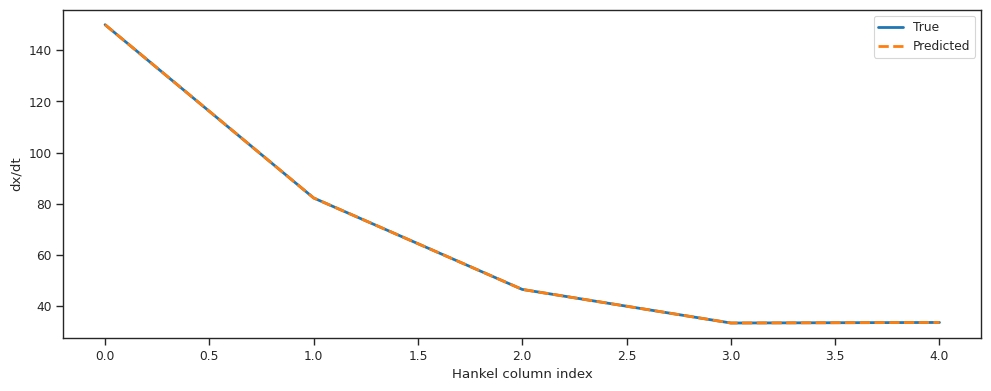

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

ell = 5
H_x = make_hankel(partial_xs[:200], ell)
H_dx = make_hankel(partial_dxs[:200], ell)
X = H_x.T
y = H_dx[0]
poly = PolynomialFeatures(degree=3, include_bias=False)
X_poly = poly.fit_transform(X)
model = LinearRegression()
model.fit(X_poly, y)
y_pred = model.predict(X_poly)
mse = np.mean((y_pred - y)**2)
plt.figure(figsize=(10, 4))
plt.plot(y, label="True", linewidth=2)
plt.plot(y_pred, "--", label="Predicted", linewidth=2)
plt.xlabel("Hankel column index")
plt.ylabel("dx/dt")
plt.legend()
plt.tight_layout()
plt.show()


## Part D - Do SVD on the Hankel matrix

Let's pick a big $\ell$. Say $\ell = 100$:
+ Form the corresponding Hankel matrix and then do SVD on it.
+ Plot the explained variance as a function of the number of singular values.
+ How much variance do you explain with three dimensions (this is the intrinsic dimensionality of the dynamical system)?
+ Visualize the first three POD modes.
+ Project the Hankel matrix columns to three dimensions (POD amplitudes/principal components).
+ Plot the time series of each one of the principal components.
+ Plot the 3D trajectory of the principal components.

**Answer:**

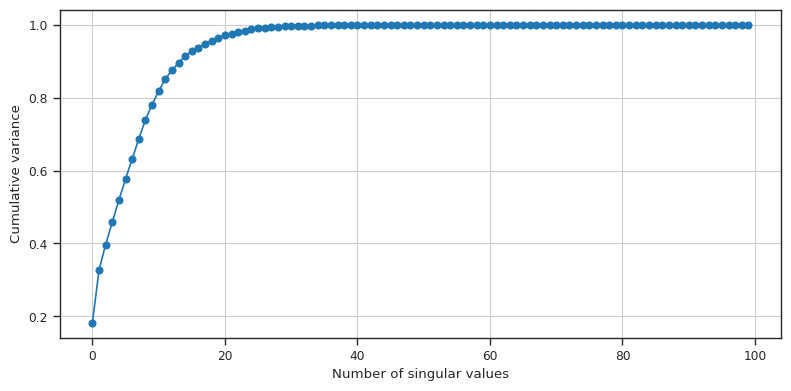

Variance explained by top 3 modes: 0.39681796262262964


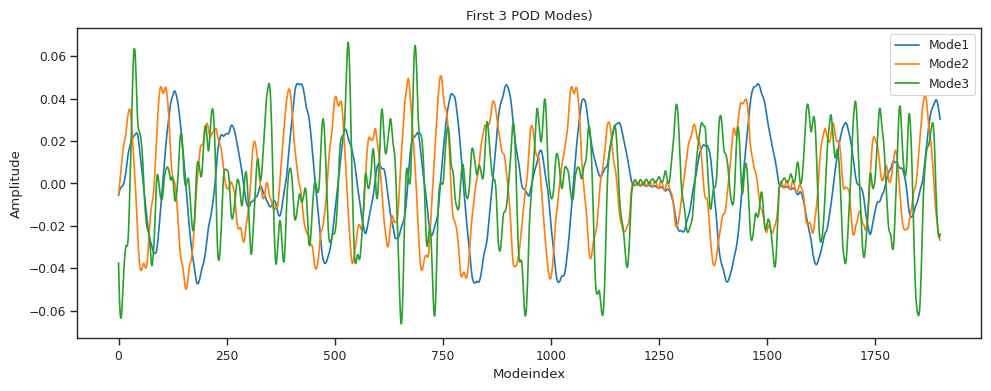

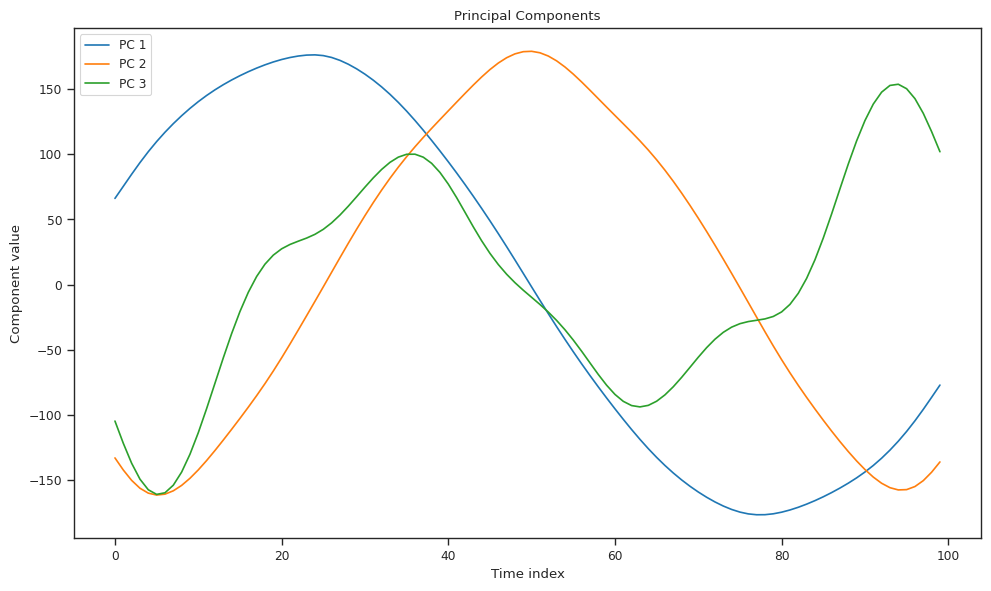

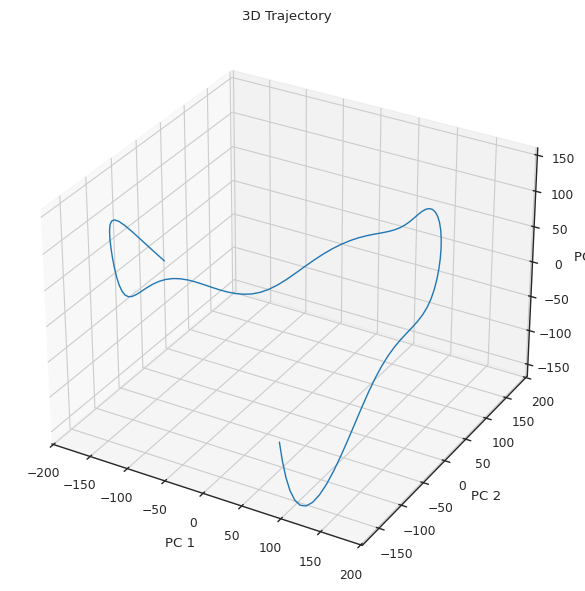

In [10]:
# as many code blocks and markdown blocks as you want
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

ell = 100
H = make_hankel(partial_xs, ell)
H_mean = np.mean(H, axis=1, keepdims=True)
H_centered = H - H_mean
U, S, VT = np.linalg.svd(H_centered, full_matrices=False)  # H ≈ U @ np.diag(S) @ VT
explained_variance = S**2 / np.sum(S**2)
plt.figure(figsize=(8, 4))
plt.plot(np.cumsum(explained_variance), marker='o')
plt.xlabel("Number of singular values")
plt.ylabel("Cumulative variance")
plt.grid(True)
plt.tight_layout()
plt.show()
variance_top3 = np.sum(explained_variance[:3])
print(f"Variance explained by top 3 modes: {variance_top3}")
plt.figure(figsize=(10, 4))
for i in range(3):
  plt.plot(U[:, i], label=f"Mode{i+1}")
plt.title("First 3 POD Modes")
plt.xlabel("Modeindex")
plt.ylabel("Amplitude")
plt.legend()
plt.tight_layout()
plt.show()
proj = U[:, :3].T @ H_centered
plt.figure(figsize=(10, 6))
for i in range(3):
  plt.plot(proj[i], label=f"PC {i+1}")
plt.title("Principal Components")
plt.xlabel("Time index")
plt.ylabel("Component value")
plt.legend()
plt.tight_layout()
plt.show()
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot(proj[0], proj[1], proj[2], linewidth=1)
ax.set_title("3D Trajectory")
ax.set_xlabel("PC 1")
ax.set_ylabel("PC 2")
ax.set_zlabel("PC 3")
plt.tight_layout()
plt.show()


## Part E - Find the time derivatives of the principal components of the Hankel matrix

To do SINDY, we need to have time derivatives.
So, you have to find the time derivatives of the principal components of the Hankel matrix.
You have two options:
+ Work out analytically how the observed `partial_dxs` will project on the POD modes, or;
+ Use numerical differentiation to find the required time derivatives (Google around for the best Python library for numerical differentiation). In this case, simple finite differences should work.

**Answer:**

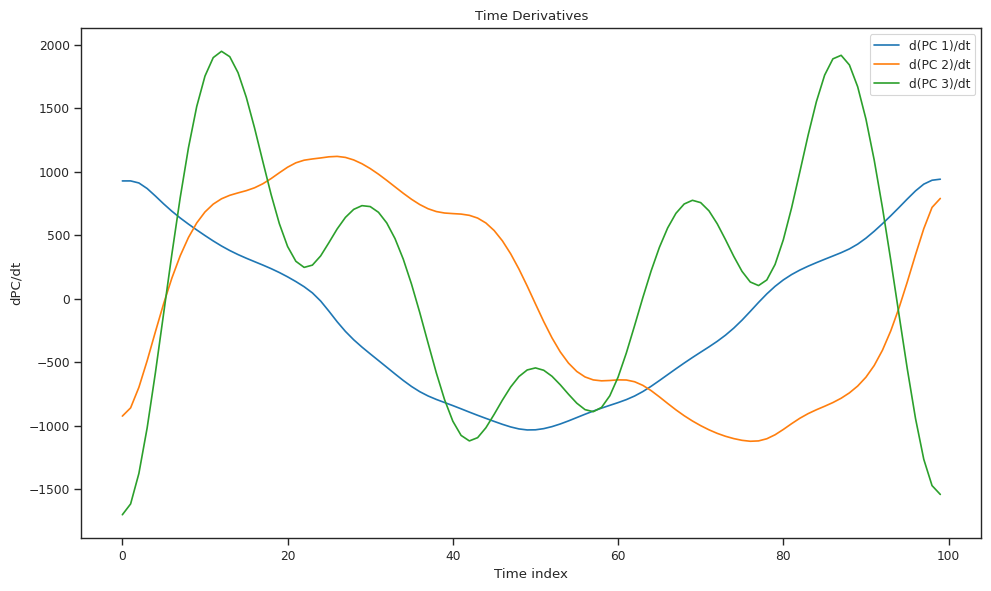

In [12]:
# as many code blocks and markdown blocks as you want
import numpy as np
import matplotlib.pyplot as plt


def finite_difference(y, dt):
  dy = np.zeros_like(y)
  dy[1:-1] = (y[2:] - y[:-2]) / (2 * dt)
  dy[0] = (y[1] - y[0]) / dt
  dy[-1] = (y[-1] - y[-2]) / dt
  return dy


ell = 100
dt = 0.01
H = make_hankel(partial_xs, ell)
H_mean = np.mean(H, axis=1, keepdims=True)
H_centered = H - H_mean
U, S, VT = np.linalg.svd(H_centered, full_matrices=False)
proj = U[:, :3].T @ H_centered
proj_dots = np.array([finite_difference(proj[i], dt) for i in range(3)])

plt.figure(figsize=(10, 6))
for i in range(3):
  plt.plot(proj_dots[i], label=f"d(PC {i+1})/dt")
plt.title("Time Derivatives")
plt.xlabel("Time index")
plt.ylabel("dPC/dt")
plt.legend()
plt.tight_layout()
plt.show()


## Part F - Do SINDY on the principal components of the Hankel matrix

You are now ready to do SINDY on the principal components of the Hankel matrix.
Use a polynomial of degree 5 as the right-hand-side.
Try to validate your results.

**Answer:**

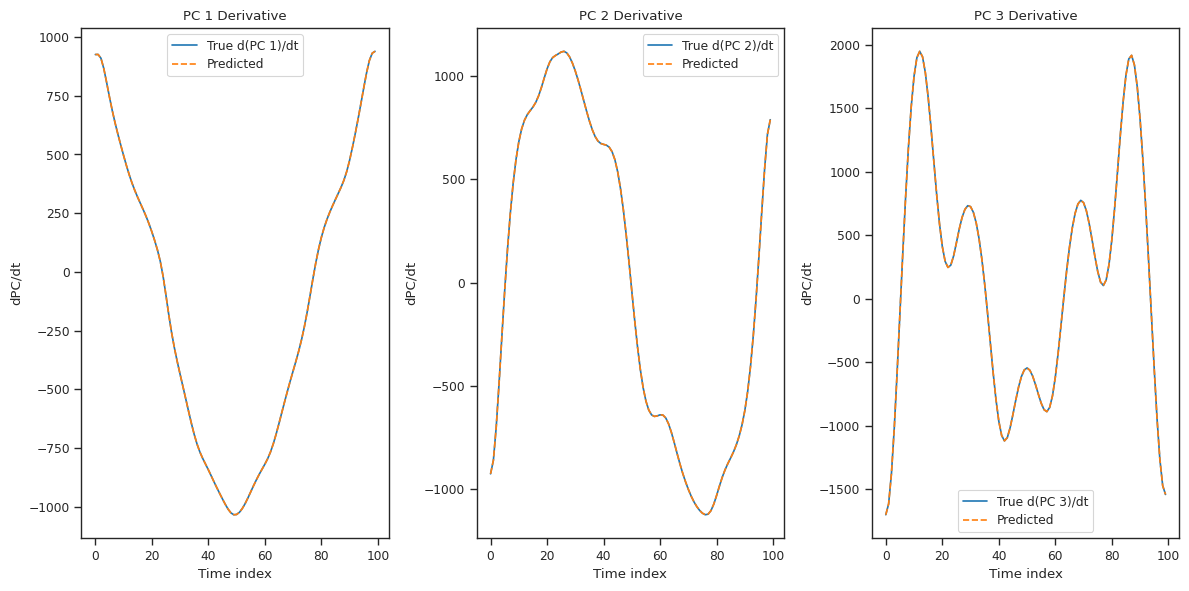

MSE for PC 1: 0.01675571056891719
MSE for PC 2: 0.0887891615272282
MSE for PC 3: 0.06337242319460042


In [13]:
# as many code blocks and markdown blocks as you want
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression


ell = 100
dt = 0.01
H = make_hankel(partial_xs, ell)
H_mean = np.mean(H, axis=1, keepdims=True)
H_centered = H - H_mean
U, S, VT = np.linalg.svd(H_centered, full_matrices=False)
proj = U[:, :3].T @ H_centered
proj_dots = np.array([finite_difference(proj[i], dt) for i in range(3)])
X = proj.T
Y = proj_dots.T
poly = PolynomialFeatures(degree=5, include_bias=False)
X_poly = poly.fit_transform(X)
models = [LinearRegression() for _ in range(3)]
Y_pred = np.zeros_like(Y)
for i in range(3):
  models[i].fit(X_poly, Y[:, i])
  Y_pred[:, i] = models[i].predict(X_poly)

plt.figure(figsize=(12, 6))
for i in range(3):
  plt.subplot(1, 3, i + 1)
  plt.plot(Y[:, i], label=f"True d(PC {i+1})/dt")
  plt.plot(Y_pred[:, i], '--', label=f"Predicted")
  plt.xlabel("Time index")
  plt.ylabel("dPC/dt")
  plt.title(f"PC {i+1} Derivative")
  plt.legend()
plt.tight_layout()
plt.show()

mse = np.mean((Y - Y_pred)**2, axis=0)
for i in range(3):
  print(f"MSE for PC {i+1}: {mse[i]}")


# Problem 2 - SINDY with measurement noise and no derivatives

Let's get back to the Lorenz system. This time, we are going to assume that we have access to the full state, but we do not have the derivative, and the measurements are corrupted by noise.
So, your available data are:

In [21]:
eta = 0.01
noisy_xs = xs + eta * np.random.normal(0, 1.0, xs.shape)

In [17]:
!pip install derivative

In [28]:
print("noisy_xs shape:", noisy_xs.shape)
print("ts shape:", ts.shape)

noisy_xs shape: (2000, 3)
ts shape: (2000,)


Review the package [derivative](https://pypi.org/project/derivative/) (which part of the `pysindy` ecosystem) and:
- Use a suitable method to estimate the derivative dx/dt from the noisy data `noisy_xs`.
- Apply SINDY to the denoised data and the numerical derivatives.
- Validate your results.

**Answer:**

MSE for dx/dt: 9.155485198012459
MSE for dy/dt: 9.44000439914245
MSE for dz/dt: 2.357371019010811


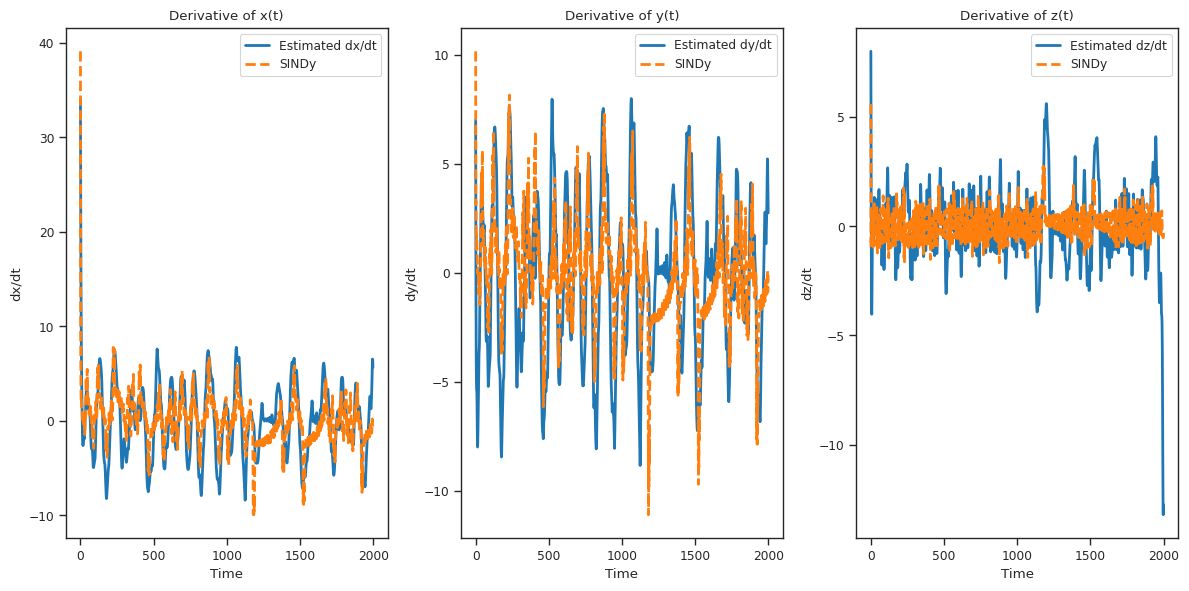

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from derivative import dxdt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
order = 3
left = 3
right = 3
dxs_hat = dxdt(
    noisy_xs.T,
    ts,
    kind='savitzky_golay',
    order=order,
    left=left,
    right=right,
    axis=1
).T
poly = PolynomialFeatures(degree=3, include_bias=False)
X_poly = poly.fit_transform(noisy_xs)

models = [LinearRegression() for _ in range(3)]
dxs_pred = np.zeros_like(dxs_hat)

for i in range(3):
  models[i].fit(X_poly, dxs_hat[:, i])
  dxs_pred[:, i] = models[i].predict(X_poly)

mse = np.mean((dxs_hat - dxs_pred) ** 2, axis=0)
for i, var in enumerate(['x', 'y', 'z']):
  print(f"MSE for d{var}/dt: {mse[i]}")

plt.figure(figsize=(12, 6))
for i, label in enumerate(['x', 'y', 'z']):
  plt.subplot(1, 3, i + 1)
  plt.plot(dxs_hat[:, i], label=f"Estimated d{label}/dt", linewidth=2)
  plt.plot(dxs_pred[:, i], '--', label="SINDy", linewidth=2)
  plt.title(f"Derivative of {label}(t)")
  plt.xlabel("Time")
  plt.ylabel(f"d{label}/dt")
  plt.legend()
plt.tight_layout()
plt.show()


# Problem 3 - Physics-informed Neural Networks for Solving a Neo-Hookean Hyperelasticity Problem

*The original version of this problem was developed by Atharva Hans as a companion to [this](https://youtu.be/o9JaZGWekWQ).

Consider a neo-Hookean square body defined on $(x,y) \in [0,1]^2$. Let $\mathbf{u}(x,y) = (u_1, u_2)$ describe the displacement field for this body.
This body is subjected to the following displacement boundary conditions:

$$
u_1(0,y) = 0,
$$

$$
u_2(0,y) = 0,
$$

$$
u_1(1,y) = \delta,
$$

$$
u_2(1,y) = 0,
$$

with $\delta$ referring to the applied displacement along the x-direction.

For this hyperelastic material, the stored energy $E_b$ in the body can be expressed in as:

$$
E_b[\mathbf{u}(\cdot)] = \int_{[0,1]^2}\left\{\frac{1}{2}(\sum_{i=1}^2\sum_{j=1}^2{F_{ij}^2} - 2)- \ln(\det(\mathbf{F})) + 50\ln(\det(\mathbf{F}))^2\right\} dxdy,
$$

with

$$
\mathbf{F} = \mathbf{I} + \nabla \mathbf{u},
$$

where $\mathbf{I}$ is an identity matrix.

The final orientation of this body is described by a displacement field that minimizes the stored energy $E_b$.
The idea is to use a neural network to approximate the displacement field and train it by minimizing the stored energy $E_b$.

To automatically satisfy the boundary conditions, we will use this approximation:
$$
u_1(x,y) = \delta - \delta(1-x) + x(1-x)N_1(x,y;\theta),
$$
and,
$$
u_2(x,y) = x(1-x)N_2(x,y;\theta)
$$
where $N_1(x,y;\theta)$ and $N_2(x,y;\theta)$ are neural networks.

## Part A

Solve the problem above for $\delta=0.1$ using a physics-informed neural network (PINN).
Use separate neural networks for $N_1(x,y;\theta)$ and $N_2(x,y;\theta)$.
Start with a multi-layer perceptron with 3 hidden layers, each with 128 units, and tanh activations.
Add a Fourier feature layer at the beginning of the network.
Feel free to change the architecture if you think it is necessary.

Use `equinox` for the neural networks and `optax` for the optimization.
Use a sampling average of 32 collocation points to compute the integral of the stored energy.
Use the Adam optimizer with a learning rate of 0.001 for 1000 iterations to debug.
Feel free to play with the learning rate, the number of collocation points, and the number of iterations.

Show the evolution of the loss function over the iterations.
Plot the final displacement field (plot $u_1(x,y)$ and $u_2(x,y)$ separately).

*Put your answer here. Use as many markdown and code blocks as you want.*

Step 0: Loss = 1394.375244
Step 100: Loss = 972.190979
Step 200: Loss = 1889.118042
Step 300: Loss = 1080.691040
Step 400: Loss = 672.507019
Step 500: Loss = 875.979919
Step 600: Loss = 1174.708374
Step 700: Loss = 1060.816162
Step 800: Loss = 1335.357178
Step 900: Loss = 642.802185


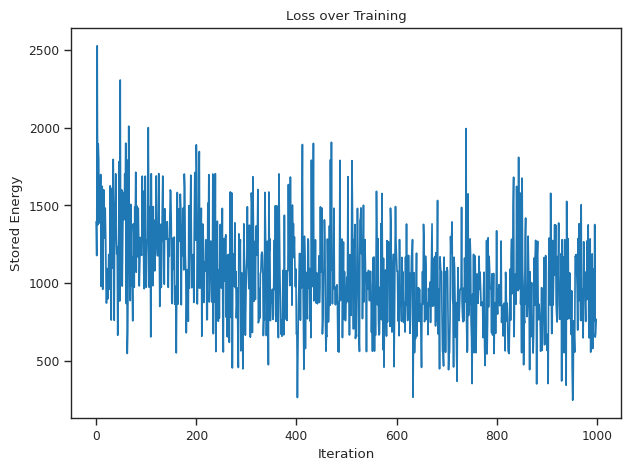

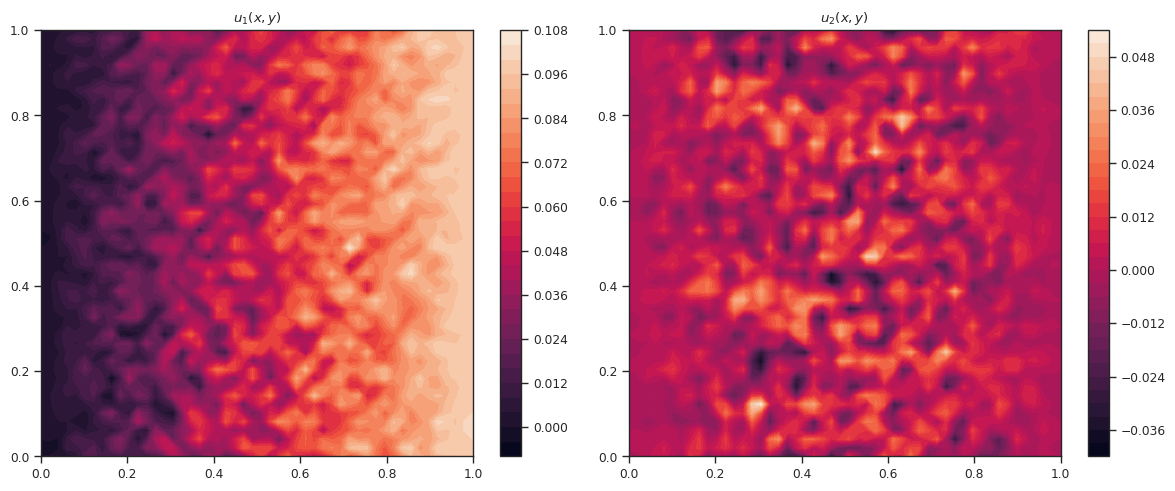

In [37]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class FourierFeatures(nn.Module):
  def __init__(self, in_features, out_features, scale=10.0):
    super().__init__()
    B = torch.randn(out_features, in_features) * scale
    self.register_buffer("B", B)

  def forward(self, x):
    x_proj = 2 * np.pi * x @ self.B.T
    return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)

class PINNNet(nn.Module):
  def __init__(self, in_features=2, fourier_features=64, hidden=128, depth=3):
    super().__init__()
    self.fourier = FourierFeatures(in_features, fourier_features)
    layers = []
    in_dim = 2 * fourier_features
    for _ in range(depth):
      layers.append(nn.Linear(in_dim, hidden))
      layers.append(nn.Tanh())
      in_dim = hidden
    layers.append(nn.Linear(hidden, 1))
    self.net = nn.Sequential(*layers)

  def forward(self, x):
    z = self.fourier(x)
    return self.net(z)

def displacement(xy, N1, N2, delta):
  x = xy[:, 0:1]
  u1 = delta - delta * (1 - x) + x * (1 - x) * N1(xy)
  u2 = x * (1 - x) * N2(xy)
  return torch.cat([u1, u2], dim=-1)

def compute_F(xy, N1, N2, delta):
  xy.requires_grad_(True)
  u = displacement(xy, N1, N2, delta)
  grads = []
  for i in range(2):
    grad = torch.autograd.grad(u[:, i].sum(), xy, create_graph=True, retain_graph=True)[0]
    grads.append(grad.unsqueeze(-1))
  du_dxy = torch.cat(grads, dim=-1)
  I = torch.eye(2, device=xy.device).unsqueeze(0).repeat(xy.shape[0], 1, 1)
  return du_dxy + I

def energy_density(F):
  J = torch.linalg.det(F)
  J_clamped = torch.clamp(J, min=1e-5)
  tr_FTF = (F ** 2).sum(dim=[1, 2])
  energy = 0.5 * (tr_FTF - 2) - torch.log(J_clamped) + 50 * torch.log(J_clamped)**2
  return energy
delta = 0.1
lr = 1e-5
n_iters = 1000
n_collocation = 64
N1 = PINNNet().to(device)
N2 = PINNNet().to(device)
optimizer = optim.Adam(list(N1.parameters()) + list(N2.parameters()), lr=lr)
loss_history = []
for step in range(n_iters):
  optimizer.zero_grad()
  xy = torch.rand(n_collocation, 2, device=device)
  F = compute_F(xy, N1, N2, delta)
  energy = energy_density(F)
  loss = energy.mean()
  loss.backward()
  optimizer.step()
  loss_history.append(loss.item())
  if step % 100 == 0:
    print(f"Step {step}: Loss = {loss.item():.6f}")

plt.figure()
plt.plot(loss_history)
plt.xlabel("Iteration")
plt.ylabel("Stored Energy")
plt.title("Loss over Training")
plt.tight_layout()
plt.show()
grid_res = 50
x = torch.linspace(0, 1, grid_res)
y = torch.linspace(0, 1, grid_res)
xx, yy = torch.meshgrid(x, y, indexing="ij")
xy_grid = torch.stack([xx.flatten(), yy.flatten()], dim=-1).to(device)
u_pred = displacement(xy_grid, N1, N2, delta)
u1_pred = u_pred[:, 0].view(grid_res, grid_res).detach().cpu()
u2_pred = u_pred[:, 1].view(grid_res, grid_res).detach().cpu()
xx, yy = xx.detach().cpu(), yy.detach().cpu()
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
cf1 = axs[0].contourf(xx, yy, u1_pred, levels=30)
axs[0].set_title(r"$u_1(x,y)$")
fig.colorbar(cf1, ax=axs[0])
cf2 = axs[1].contourf(xx, yy, u2_pred, levels=30)
axs[1].set_title(r"$u_2(x,y)$")
fig.colorbar(cf2, ax=axs[1])
plt.tight_layout()
plt.show()


In [32]:
!pip install equinox optax jax matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.1/177.1 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.4/55.4 kB 4.3 MB/s eta 0:00:00


## Part B

Solve the problem for $\delta=0.5$ using the same architecture as above.
It will likely fail to train.
If yes, then use the solution of $\delta=0.1$ as the initial guess for $\delta=0.2$, and then use the solution of $\delta=0.2$ as the initial guess for $\delta=0.3$, and so on, until you reach $\delta=0.5$.
This is called transfer learning.

At the end, plot the final displacement field for $\delta=0.5$.

*Put your answer here. Use as many markdown and code blocks as you want.*

In [38]:
# your code here

deltas = [0.1, 0.2, 0.3, 0.4, 0.5]
n_iters = 1000
lr = 1e-4
batch_size = 32
loss_histories = []

for delta in deltas:
  optimizer = optim.Adam(list(N1.parameters()) + list(N2.parameters()), lr=lr)
  loss_history = []
  for step in range(n_iters):
    optimizer.zero_grad()
    xy = torch.rand(batch_size, 2, device=device)
    F = compute_F(xy, N1, N2, delta)
    energy = energy_density(F)
    loss = energy.mean()
    loss.backward()
    optimizer.step()
    loss_history.append(loss.item())
    if step % 100 == 0:
      print(f"δ={delta:.1f}, Step {step}: Loss = {loss.item():.6f}")
    loss_histories.append(loss_history)


δ=0.1, Step 0: Loss = 1077.837524
δ=0.1, Step 100: Loss = 656.895996
δ=0.1, Step 200: Loss = 440.819672
δ=0.1, Step 300: Loss = 264.130005
δ=0.1, Step 400: Loss = 231.785843
δ=0.1, Step 500: Loss = 240.575912
δ=0.1, Step 600: Loss = 21.534016
δ=0.1, Step 700: Loss = 11.417553
δ=0.1, Step 800: Loss = 3.047693
δ=0.1, Step 900: Loss = 8.241138
δ=0.2, Step 0: Loss = 4.920318
δ=0.2, Step 100: Loss = 2.763455
δ=0.2, Step 200: Loss = 1.930254
δ=0.2, Step 300: Loss = 1.636476
δ=0.2, Step 400: Loss = 1.831942
δ=0.2, Step 500: Loss = 2.076631
δ=0.2, Step 600: Loss = 1.969241
δ=0.2, Step 700: Loss = 2.065035
δ=0.2, Step 800: Loss = 1.845444
δ=0.2, Step 900: Loss = 1.352363
δ=0.3, Step 0: Loss = 3.717098
δ=0.3, Step 100: Loss = 4.330170
δ=0.3, Step 200: Loss = 3.192378
δ=0.3, Step 300: Loss = 4.144142
δ=0.3, Step 400: Loss = 3.189859
δ=0.3, Step 500: Loss = 3.618417
δ=0.3, Step 600: Loss = 4.107741
δ=0.3, Step 700: Loss = 4.305460
δ=0.3, Step 800: Loss = 3.558269
δ=0.3, Step 900: Loss = 3.953694
δ

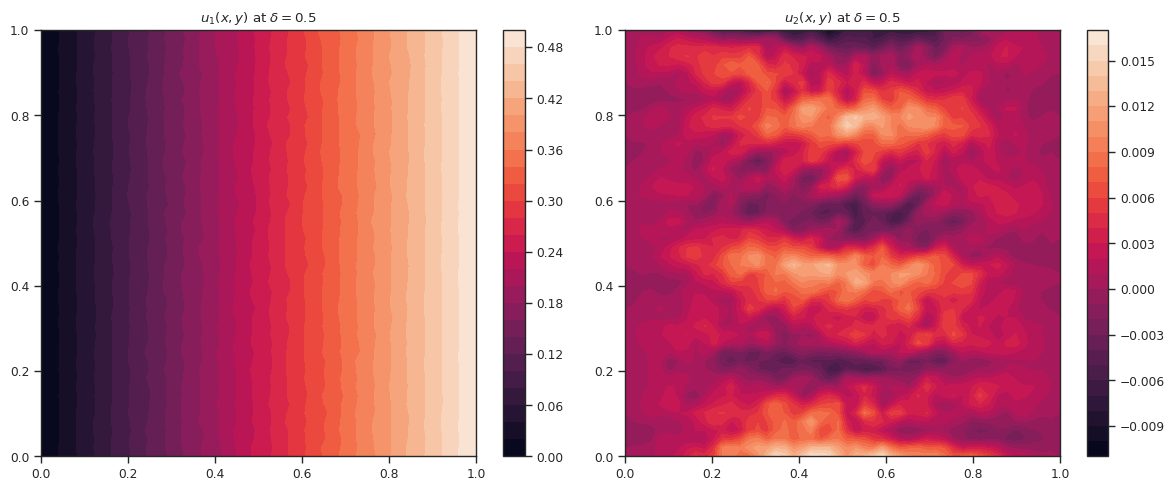

In [39]:
grid_res = 50
x = torch.linspace(0, 1, grid_res)
y = torch.linspace(0, 1, grid_res)
xx, yy = torch.meshgrid(x, y, indexing="ij")
xy_grid = torch.stack([xx.flatten(), yy.flatten()], dim=-1).to(device)
u_pred = displacement(xy_grid, N1, N2, delta=0.5)
u1_pred = u_pred[:, 0].view(grid_res, grid_res).detach().cpu()
u2_pred = u_pred[:, 1].view(grid_res, grid_res).detach().cpu()
xx, yy = xx.cpu(), yy.cpu()

fig, axs = plt.subplots(1, 2, figsize=(12, 5))
cf1 = axs[0].contourf(xx, yy, u1_pred, levels=30)
axs[0].set_title(r"$u_1(x,y)$ at $\delta=0.5$")
fig.colorbar(cf1, ax=axs[0])
cf2 = axs[1].contourf(xx, yy, u2_pred, levels=30)
axs[1].set_title(r"$u_2(x,y)$ at $\delta=0.5$")
fig.colorbar(cf2, ax=axs[1])
plt.tight_layout()
plt.show()


## Part C

Solve the parametric problem for $\delta \in [0,0.5]$. That is, build a neural network that takes $\delta$ as input and outputs the displacement field. To do this:
+ Modify the loss function to:

$$
\mathcal{L} = \int_0^{0.5} \int_{[0,1]^2} \left\{\frac{1}{2}(\sum_{i}\sum_{j}{F_{ij}^2} - 2)- \ln(\det(\mathbf{F})) + 50\ln(\det(\mathbf{F}))^2\right\} dxdy d\delta.
$$

+ Modify the neural networks to take $\delta$ as input, say $N_1(x,y;\delta;\theta)$ and $N_2(x,y;\delta;\theta)$. Your field will be $\mathbf{u}(x,y;\delta;\theta)$.
Use the following architecture for the neural networks:

$$
N_1(x,y;\delta) = \sum_{i=1}^n b_{1,i}(\delta)t_{1,i}(x,y).
$$

Here, $n$ is your choice (start with $n=10$), $b_{1,i}$ is a neural network that takes $\delta$ as input and outputs a scalar, and $t_{1,i}(x,y)$ is a multi-layer perceptron with 3 hidden layers, each with 128 units, and tanh activations, and Fourier features at the beginning. The same applies to $N_2(x,y;\delta)$. This representation resembles an expansion in terms of basis functions.
The same architecture appears in DeepONet.

Plot the $x$ and $y$ displacement at $x=0.5, y=0.5$ as a function of $\delta$.

*Put your answer here. Use as many markdown and code blocks as you want.*

In [40]:
# your code here
class BranchNet(nn.Module):
  def __init__(self, n_basis=10):
    super().__init__()
    self.net = nn.Sequential(nn.Linear(1, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, n_basis)
        )

  def forward(self, delta):
    return self.net(delta)
class TrunkNet(nn.Module):
  def __init__(self, in_features=2, fourier_features=64, n_basis=10):
    super().__init__()
    self.fourier = FourierFeatures(in_features, fourier_features)
    self.basis_fns = nn.ModuleList([nn.Sequential(
                nn.Linear(2 * fourier_features, 128),
                nn.Tanh(),
                nn.Linear(128, 128),
                nn.Tanh(),
                nn.Linear(128, 128),
                nn.Tanh(),
                nn.Linear(128, 1)
            ) for _ in range(n_basis)
        ])

  def forward(self, xy):
    z = self.fourier(xy)
    return torch.cat([fn(z) for fn in self.basis_fns], dim=1)  # (N, n_basis)


In [41]:
def N_parametric(xy, delta, trunk_net, branch_net):
  B = branch_net(delta)
  T = trunk_net(xy)
  return (B * T).sum(dim=1, keepdim=True)


In [42]:
def displacement_parametric(xy, delta, trunk1, branch1, trunk2, branch2):
  x = xy[:, 0:1]
  N1_val = N_parametric(xy, delta, trunk1, branch1)
  N2_val = N_parametric(xy, delta, trunk2, branch2)
  u1 = delta - delta * (1 - x) + x * (1 - x) * N1_val
  u2 = x * (1 - x) * N2_val
  return torch.cat([u1, u2], dim=-1)


In [43]:
def loss_fn(tr1, br1, tr2, br2, batch_size=64):
  xy = torch.rand(batch_size, 2, device=device)
  delta = torch.rand(batch_size, 1, device=device) * 0.5
  xy.requires_grad_(True)
  u = displacement_parametric(xy, delta, tr1, br1, tr2, br2)
  grads = [torch.autograd.grad(u[:, i].sum(), xy, create_graph=True)[0] for i in range(2)]
  du_dxy = torch.stack(grads, dim=2)  # (N, 2, 2)
  I = torch.eye(2, device=device).unsqueeze(0)
  F = du_dxy + I
  J = torch.linalg.det(F)
  J_clamped = torch.clamp(J, min=1e-5)
  tr_FTF = (F ** 2).sum(dim=[1, 2])
  energy = 0.5 * (tr_FTF - 2) - torch.log(J_clamped) + 50 * torch.log(J_clamped) ** 2
  return energy.mean()


Step 0: Loss = 548.554077
Step 100: Loss = 4.793335
Step 200: Loss = 2.704229
Step 300: Loss = 3.508845
Step 400: Loss = 3.696606
Step 500: Loss = 2.688950
Step 600: Loss = 3.579524
Step 700: Loss = 2.999886
Step 800: Loss = 3.560145
Step 900: Loss = 2.807071
Step 1000: Loss = 3.241162
Step 1100: Loss = 3.447484
Step 1200: Loss = 2.542932
Step 1300: Loss = 3.198627
Step 1400: Loss = 2.895247
Step 1500: Loss = 2.934252
Step 1600: Loss = 3.089984
Step 1700: Loss = 3.307054
Step 1800: Loss = 2.637540
Step 1900: Loss = 3.294541


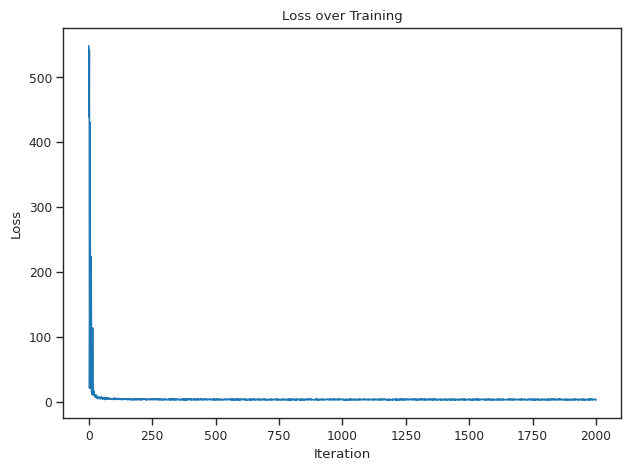

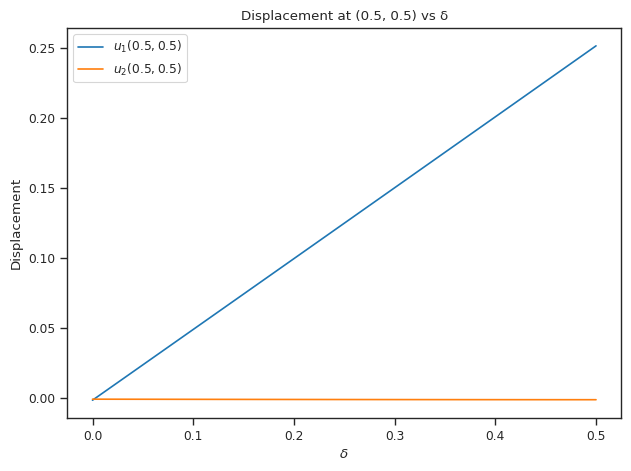

In [44]:
n_basis = 10
trunk1 = TrunkNet(n_basis=n_basis).to(device)
branch1 = BranchNet(n_basis=n_basis).to(device)
trunk2 = TrunkNet(n_basis=n_basis).to(device)
branch2 = BranchNet(n_basis=n_basis).to(device)

params = list(trunk1.parameters()) + list(branch1.parameters()) + \
         list(trunk2.parameters()) + list(branch2.parameters())
optimizer = optim.Adam(params, lr=1e-4)
n_iters = 2000
loss_history = []

for step in range(n_iters):
  optimizer.zero_grad()
  loss = loss_fn(trunk1, branch1, trunk2, branch2)
  loss.backward()
  optimizer.step()
  loss_history.append(loss.item())
  if step % 100 == 0:
    print(f"Step {step}: Loss = {loss.item():.6f}")

plt.plot(loss_history)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Loss over Training")
plt.tight_layout()
plt.show()

with torch.no_grad():
  delta_vals = torch.linspace(0, 0.5, 100).unsqueeze(1).to(device)
  xy_mid = torch.tensor([[0.5, 0.5]], device=device).repeat(len(delta_vals), 1)
  u_vals = displacement_parametric(xy_mid, delta_vals, trunk1, branch1, trunk2, branch2)
  u1_vals = u_vals[:, 0].cpu()
  u2_vals = u_vals[:, 1].cpu()

plt.plot(delta_vals.cpu(), u1_vals, label=r"$u_1(0.5, 0.5)$")
plt.plot(delta_vals.cpu(), u2_vals, label=r"$u_2(0.5, 0.5)$")
plt.xlabel(r"$\delta$")
plt.ylabel("Displacement")
plt.title("Displacement at (0.5, 0.5) vs δ")
plt.legend()
plt.tight_layout()
plt.show()